# 支持向量机

In [307]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sns.set() # 默认绘图风格

### 支持向量基本原理


<img src="../images/3.png", width="900">

如何解决这个线性不可分问题呢？咱们给它映射到高维来试试

$z=x^2+y^2$.


## 例子

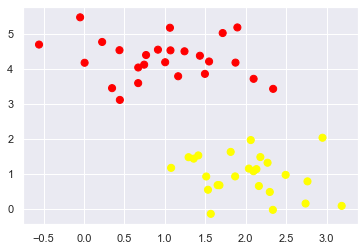

In [308]:
# 随机生成数据
from sklearn.datasets.samples_generator import make_blobs # 聚类数据
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.6) # cluster_std 分散幅度
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

随机画线

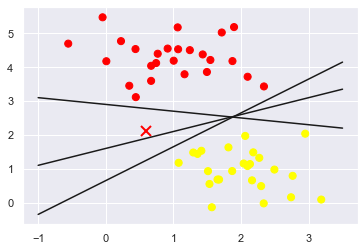

In [309]:
x_fit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
# 怎么画的线？
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(x_fit, m * x_fit + b, '-k')


## Support Vector Machines:最小化 *雷区*

(-1, 3.5)

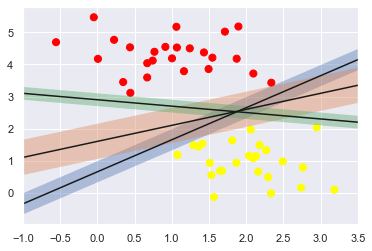

In [310]:
x_fit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    y_fit = m * x_fit + b
    plt.plot(x_fit, y_fit, '-k')
    plt.fill_between(x_fit, y_fit - d, y_fit + d, edgecolor='none', alpha=0.4)

plt.xlim(-1, 3.5)

### 训练一个基本的SVM


In [311]:
from sklearn.svm import SVC # 'support vector classifier'
model = SVC(kernel='linear')
model.fit(X, y)


SVC(kernel='linear')

In [312]:
# 绘图函数
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca() # 创建画布
    #     Get the current :class:`~matplotlib.axes.Axes` instance on the
    # current figure matching the given keyword args, or create one.
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y,x) # (30, 30) # 画等高线用
    xy = np.vstack([X.ravel(), Y.ravel()]).T  # (900,2)
    P = model.decision_function(xy).reshape(X.shape)  # (30,30)   计算样本点到分割超平面的函数距离  获得每个分类器的( n* ( n-1 )/2 数字总数的输出
    # print(P.shape)

    # plot decision boundary and margins
    # contour 轮廓  等高线图
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=50, linewidth=1, alpha=0.9);
    # 支持向量画圈
    # plt.scatter(model.support_vectors_[:, 0],
    #                model.support_vectors_[:, 1],
    #                s=300, linewidth=1, alpha=0.3)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

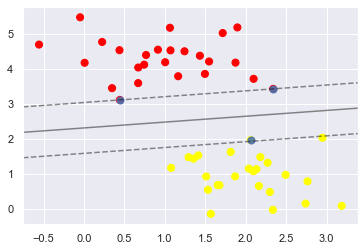

In [313]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

* 这条线就是我们希望得到的决策边界啦

* 观察发现有3个点做了特殊的标记，它们恰好都是边界上的点

* 它们就是我们的*support vectors*（支持向量）

* 在Scikit-Learn中, 它们存储在这个位置 ``support_vectors_``（一个属性）


In [314]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

* 观察可以发现，只需要支持向量我们就可以把模型构建出来

* 接下来我们尝试一下，用不同多的数据点，看看效果会不会发生变化

* 分别使用60个和120个数据点

AxesSubplot(0.125,0.125;0.31x0.755) 60
AxesSubplot(0.59,0.125;0.31x0.755) 120


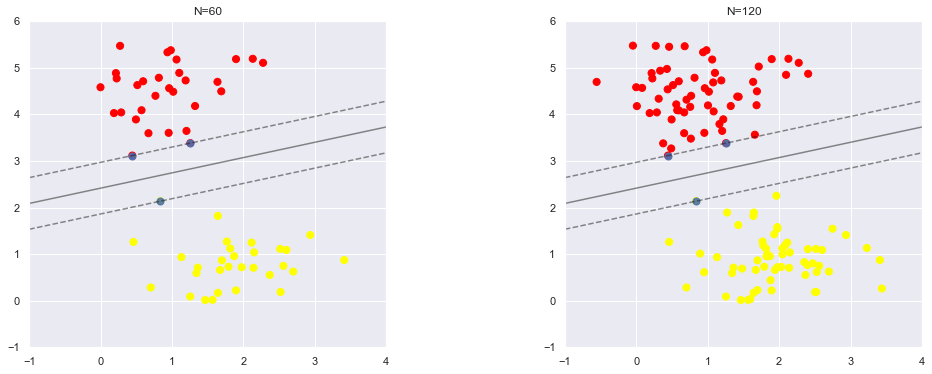

In [315]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10) # C惩罚参数
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# ax[1],ax[2]
fig.subplots_adjust(wspace=0.5,hspace=0.5)
for axi, N in zip(ax, [60, 120]):
    print(axi, N)
    plot_svm(N, axi)
    axi.set_title('N={0}'.format(N))

* 左边是60个点的结果，右边的是120个点的结果
* 观察发现，只要支持向量没变，其他的数据怎么加无所谓！

### 引入核函数的SVM
* 首先我们先用线性的核来看一下在下面这样比较难的数据集上还能分了吗？


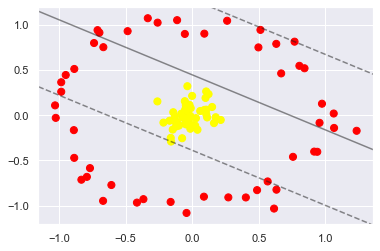

In [316]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=0.1, noise=0.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y ,s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

* 坏菜喽，分不了了，那咋办呢？试试高维核变换吧！

* We can visualize this extra data dimension using a three-dimensional plot:

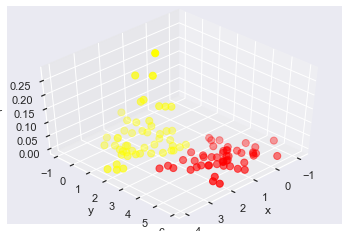

In [331]:
r = np.exp(-(X ** 2).sum(1)) # sum(1) 列位置
def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:,1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim) # 视角切换
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
plot_3D(elev=45, azim=45, X=X, y=y)

In [329]:
# 加入径向基函数，高斯变换
clf = SVC(kernel='rbf', C=1E6) # 核函数，默认是rbf，可以是‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
clf.fit(X, y)

SVC(C=1000000.0)

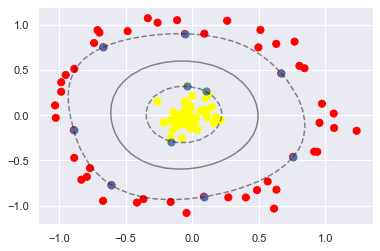

In [326]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

使用这种核支持向量机，我们学习一个合适的非线性决策边界。这种核变换策略在机器学习中经常被使用！

### 调节SVM参数: Soft Margin问题

### 调节C参数
* 当C趋近于无穷大时：意味着分类严格不能有错误
* 当C趋近于很小的时：意味着可以有更大的错误容忍

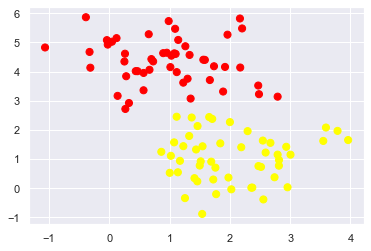

In [327]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

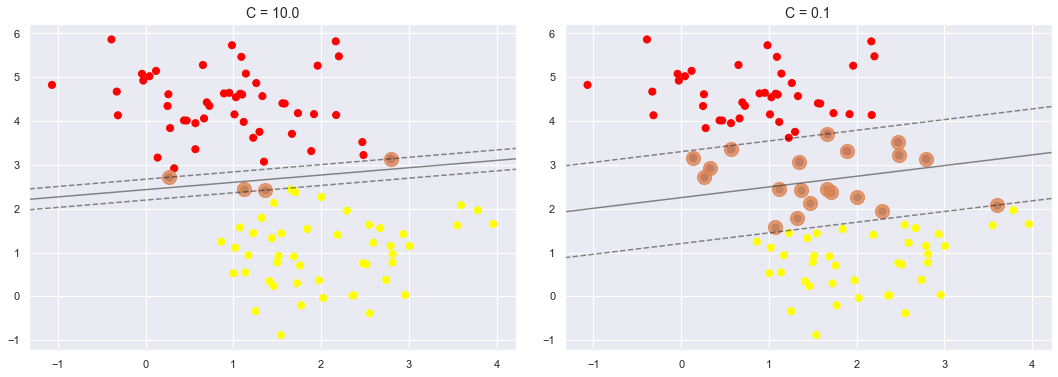

In [342]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=200, lw=1, alpha=0.8);
    axi.set_title('C = {0:.1f}'.format(C), size=14)

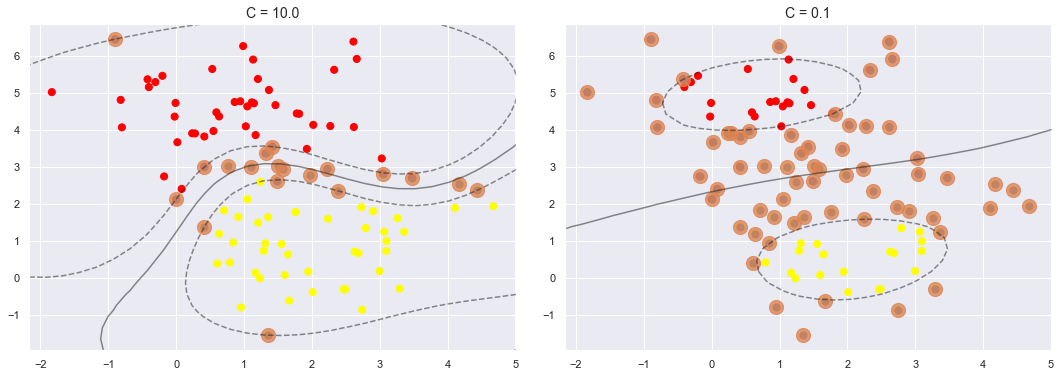

In [343]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='rbf', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=200, lw=1, alpha=0.8);
    axi.set_title('C = {0:.1f}'.format(C), size=14)

##示例：人脸识别

作为运行中的支持向量机的示例，让我们看一下面部识别问题。
我们将使用Wild数据集中的Labeled Faces，其中包含数千张各种公众人物的整理照片。
Scikit-Learn内置了数据集的提取程序：

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:


In [353]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

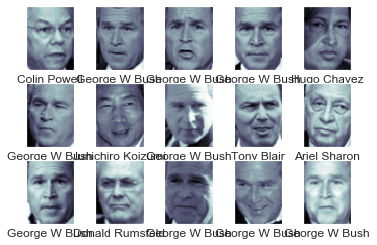

In [361]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat): # 将整个numpy对象转换成了1维对象，然后遍历
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

* 每个图的大小是 [62×47]
* 在这里我们就把每一个像素点当成了一个特征，但是这样特征太多了，用PCA降维一下吧！

In [363]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [364]:
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca,svc)

In [365]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=40)

使用grid search cross-validation来选择我们的参数

In [366]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10]}
grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 21.8 s, sys: 407 ms, total: 22.2 s
Wall time: 9.24 s
{'svc__C': 1}


In [367]:
model = grid.best_estimator_
yfit = model.predict(Xtest)
yfit.shape

(337,)

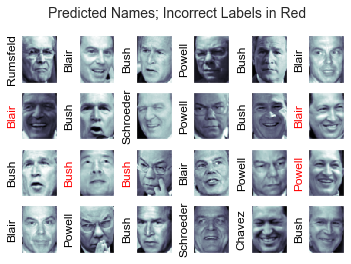

In [370]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [371]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.44      0.61        16
     Colin Powell       0.55      0.91      0.69        54
  Donald Rumsfeld       0.91      0.85      0.88        34
    George W Bush       0.88      0.90      0.89       136
Gerhard Schroeder       0.91      0.74      0.82        27
      Hugo Chavez       1.00      0.44      0.62        18
Junichiro Koizumi       1.00      0.67      0.80        15
       Tony Blair       0.90      0.76      0.82        37

         accuracy                           0.81       337
        macro avg       0.89      0.71      0.76       337
     weighted avg       0.85      0.81      0.81       337



* 精度(precision) = 正确预测的个数(TP)/被预测正确的个数(TP+FP)
* 召回率(recall)=正确预测的个数(TP)/预测个数(TP+FN)
* F1 = 2*精度*召回率/(精度+召回率)

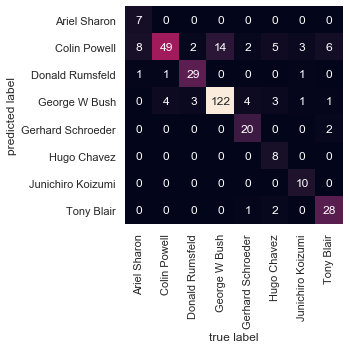

In [372]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');